<a href="https://colab.research.google.com/github/gtejaswani/sample/blob/master/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

In [3]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

     |████████████████████████████████| 24.2MB 158kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)
     |████████████████████████████████| 10.5MB 2.5MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 1.1.2 which is incompatible.
  Found existing installation: pandas 1.0.5
    Uninstalling pandas-1.0.5:
      Successfully uninstalled pandas-1.0.5


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [7]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [8]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
path=("/content/drive/My Drive/Copy of 1.csv")
df = pd.read_csv(path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [10]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [53]:
df.head

<bound method NDFrame.head of            target  ...                                               text
0        NEGATIVE  ...       awww bummer shoulda got david carr third day
1        NEGATIVE  ...  upset update facebook texting might cry result...
2        NEGATIVE  ...  dived many times ball managed save 50 rest go ...
3        NEGATIVE  ...                   whole body feels itchy like fire
4        NEGATIVE  ...                                   behaving mad see
...           ...  ...                                                ...
1599995  POSITIVE  ...                      woke school best feeling ever
1599996  POSITIVE  ...           thewdb com cool hear old walt interviews
1599997  POSITIVE  ...                    ready mojo makeover ask details
1599998  POSITIVE  ...  happy 38th birthday boo alll time tupac amaru ...
1599999  POSITIVE  ...  happy charitytuesday thenspcc sparkscharity sp...

[1600000 rows x 6 columns]>

### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [15]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [16]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 530 ms, sys: 0 ns, total: 530 ms
Wall time: 545 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

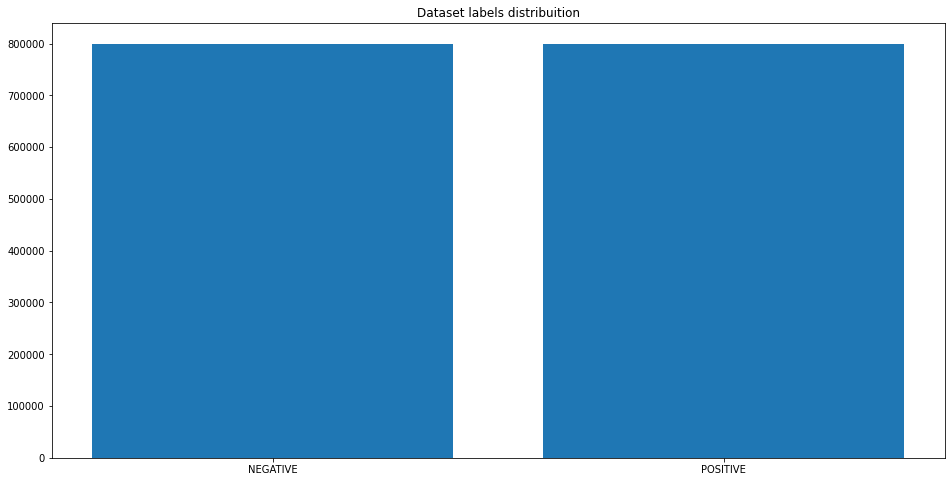

In [17]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [18]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [19]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [20]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 45.7 s, sys: 303 ms, total: 46 s
Wall time: 46.2 s


### Split train and test

In [21]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [23]:
%%time
documents = [_text.split() for _text in df_train.text] 
import os
path=("/content/drive/My Drive/Copy of model.w2v")
model_exists = os.path.isfile('path')

CPU times: user 3.17 s, sys: 843 ms, total: 4.01 s
Wall time: 4.03 s


In [24]:
if model_exists:
    from gensim.models import Word2Vec
    w2v_model=Word2Vec.load(r"/content/drive/My Drive/Colab Notebooks/model.w2v")
    print("w2v model exists, existing model loaded.")
else:
    w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [25]:
if not model_exists:
    w2v_model.build_vocab(documents)

2020-09-26 08:41:30,547 : INFO : collecting all words and their counts
2020-09-26 08:41:30,548 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-26 08:41:30,588 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-09-26 08:41:30,621 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-09-26 08:41:30,647 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-09-26 08:41:30,679 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-09-26 08:41:30,707 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-09-26 08:41:30,737 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-09-26 08:41:30,777 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-09-26 08:41:30,815 : INFO : PROGRESS: at s

In [26]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [27]:
w2v_model.wv['model'].shape

(300,)

In [28]:
%%time
if model_exists==False:
    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
else:
    print("Trained model loaded")

2020-09-26 08:42:44,153 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-09-26 08:42:45,237 : INFO : EPOCH 1 - PROGRESS: at 2.93% examples, 229588 words/s, in_qsize 15, out_qsize 0
2020-09-26 08:42:46,245 : INFO : EPOCH 1 - PROGRESS: at 6.51% examples, 259972 words/s, in_qsize 14, out_qsize 1
2020-09-26 08:42:47,265 : INFO : EPOCH 1 - PROGRESS: at 10.42% examples, 278124 words/s, in_qsize 15, out_qsize 0
2020-09-26 08:42:48,326 : INFO : EPOCH 1 - PROGRESS: at 14.00% examples, 277758 words/s, in_qsize 15, out_qsize 0
2020-09-26 08:42:49,379 : INFO : EPOCH 1 - PROGRESS: at 17.68% examples, 279678 words/s, in_qsize 15, out_qsize 0
2020-09-26 08:42:50,449 : INFO : EPOCH 1 - PROGRESS: at 21.35% examples, 280834 words/s, in_qsize 15, out_qsize 3
2020-09-26 08:42:51,563 : INFO : EPOCH 1 - PROGRESS: at 25.26% examples, 281479 words/s, in_qsize 16, out_qsize 2
2020-09-26 08:42:52,630 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 28min 55s, sys: 8.4 s, total: 29min 3s
Wall time: 15min 3s


In [40]:
w2v_model.most_similar("love")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('luv', 0.5888869166374207),
 ('loves', 0.5708596706390381),
 ('loved', 0.5283610820770264),
 ('adore', 0.5163772106170654),
 ('amazing', 0.4994962811470032),
 ('looove', 0.48800984025001526),
 ('awesome', 0.4608444571495056),
 ('loveee', 0.4424547255039215),
 ('lovee', 0.4415190815925598),
 ('loooove', 0.43893131613731384)]

### Tokenize Text

In [41]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 19.1 s, sys: 102 ms, total: 19.2 s
Wall time: 19.2 s


In [37]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 27.3 s, sys: 1.24 s, total: 28.6 s
Wall time: 28.7 s


### Label Encoder 

In [42]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [43]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [44]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [45]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [46]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [47]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [48]:
model_exists=os.path.isfile('/content/drive/My Drive/Copy of model.h5')
if model_exists:
    from keras.models import load_model
    model = load_model('/content/drive/My Drive/Copy of model.h5')
    print("Keras model file found and loaded.")
else:
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))

model.summary()

Keras model file found and loaded.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [49]:
if not model_exists:
    model.compile(loss='binary_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
else:
    print("Compiled Model Loaded.")

Compiled Model Loaded.


### Callbacks

In [50]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [51]:
%%time
if not model_exists:#if model doesn't exist, fit the model on the training set
    from keras.callbacks import CSVLogger

    csv_logger = CSVLogger('training.log', separator=',', append=False)
    history = model.fit(x_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_split=0.1,
                        verbose=1,
                        callbacks=callbacks)
    #storing history for visualization
    pickle_out = open("../input/trained-model/history.pickle","wb")
    pickle.dump(history.histpry, pickle_out)
    pickle_out.close()
else:
    if os.path.isfile('../input/trained-model/history.pickle'):
        history=pickle.load('../input/trained-model/history.pickle')
        print("History file found and loaded.")

CPU times: user 530 µs, sys: 5 µs, total: 535 µs
Wall time: 323 µs


### Evaluate

In [52]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 1235s 4s/step - loss: 0.4443 - accuracy: 0.7911

ACCURACY: 0.7911343574523926
LOSS: 0.44429531693458557
CPU times: user 28min 43s, sys: 7min 22s, total: 36min 6s
Wall time: 20min 40s


### Predict

In [54]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [55]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [56]:
predict("I love the music")

{'elapsed_time': 0.4449467658996582,
 'label': 'POSITIVE',
 'score': 0.9656286239624023}

In [57]:
predict("I hate the rain")

{'elapsed_time': 0.12054085731506348,
 'label': 'NEGATIVE',
 'score': 0.01075369119644165}

In [58]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.10913848876953125,
 'label': 'NEGATIVE',
 'score': 0.2742375135421753}

In [59]:
predict("teju likes to dance")

{'elapsed_time': 0.10303282737731934,
 'label': 'POSITIVE',
 'score': 0.8790203332901001}

In [60]:
predict("i am going out")

{'elapsed_time': 0.10097956657409668,
 'label': 'NEUTRAL',
 'score': 0.5986215472221375}

### Confusion Matrix

In [61]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 1035s 26s/step
CPU times: user 26min 25s, sys: 7min 12s, total: 33min 37s
Wall time: 17min 45s


In [62]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

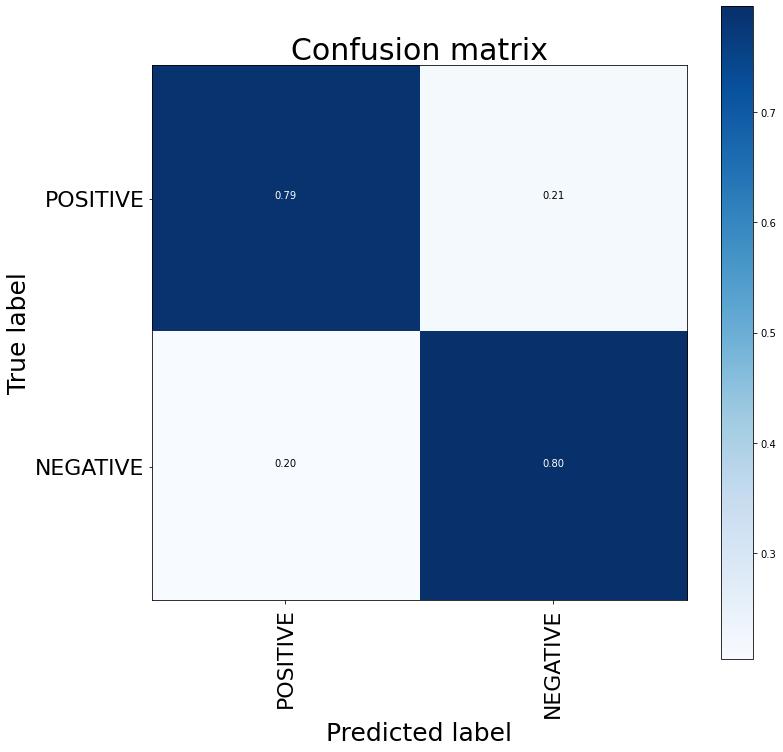

CPU times: user 1.27 s, sys: 31.6 ms, total: 1.3 s
Wall time: 1.39 s


In [63]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [64]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.79      0.79    159494
    POSITIVE       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



### Accuracy Score

In [65]:
accuracy_score(y_test_1d, y_pred_1d)

0.791134375

### Save model

In [66]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-09-26 10:03:13,535 : INFO : saving Word2Vec object under model.w2v, separately None
2020-09-26 10:03:13,537 : INFO : not storing attribute vectors_norm
2020-09-26 10:03:13,538 : INFO : not storing attribute cum_table
2020-09-26 10:03:14,592 : INFO : saved model.w2v
